In [1]:
import pandas as pd
import numpy as np
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from tqdm import tqdm, tqdm_notebook
from collections import Counter
import pickle
from multiprocessing import Pool, cpu_count
from functools import partial
import utils

In [2]:
import importlib
importlib.reload(utils)

<module 'utils' from 'D:\\Netology\\Diplom\\utils.py'>

In [3]:
tqdm.pandas()

In [4]:
df = pd.read_excel('data/test_data.xlsx', usecols=['class', 'text'])

In [5]:
df.head()

,class,text
0,отмена заказа,"""Добрый день! Сообщаю, что , к сожалению, в..."
1,отмена заказа,"""Добрый день! Хочу отменить Заказы:#200286822..."
2,перезвонить,наталья калинина [email] Westwing перез...
3,отказ от рассылки,"""Людмила Цой [email] Westwing Добрый де..."
4,изменения в заказе,"""Анна добрый день! Нас не будет в городе в пер..."


In [6]:
df['class'].value_counts()

удалить                  384
подтверждение заказа     213
вопрос                   102
отмена заказа             94
жалоба                    69
изменения в заказе        67
отказ от рассылки         65
проблемы                  38
статус заказа             38
возврат                   36
статус заказа+            33
удаление аккаунта         22
подтверждение заказа+     22
перезвонить                7
получить часть заказа      7
Name: class, dtype: int64

In [7]:
df['class'].value_counts(normalize=True)

удалить                  0.320802
подтверждение заказа     0.177945
вопрос                   0.085213
отмена заказа            0.078530
жалоба                   0.057644
изменения в заказе       0.055973
отказ от рассылки        0.054302
проблемы                 0.031746
статус заказа            0.031746
возврат                  0.030075
статус заказа+           0.027569
удаление аккаунта        0.018379
подтверждение заказа+    0.018379
перезвонить              0.005848
получить часть заказа    0.005848
Name: class, dtype: float64

In [8]:
classes_change = {'вопрос': 'вопрос/жалоба', 'жалоба': 'вопрос/жалоба', 
                  'получить часть заказа': 'изменения в заказе', 'проблемы': 'вопрос/жалоба'}

In [9]:
df['class'] = df['class'].map(classes_change).fillna(df['class'])

In [10]:
df.rename_axis('Index', inplace=True)

In [11]:
df.dropna(inplace=True)

In [12]:
text1 = '"Я уже отказалась! А вы все продолжаете слать, может хватит уже. Спасибо!!!    Среда, 29 мая 2013, 14:31 +02:00'
        
text1 = re.sub('    (Понедельник|Вторник|Среда|Четверг|Пятница|Суббота|Воскресенье), [0-9]{1,2}.{1,}', '', text1)
text1

'"Я уже отказалась! А вы все продолжаете слать, может хватит уже. Спасибо!!!'

In [13]:
def clean_text(text):
    text = re.sub('[А-Яа-яЁё ]{1,}\[email\]    [А-Яа-яЁёA-Za-z ]{1,}    ', '', text)
    text = re.sub('Sent from my iP.{1,}', '', text)
    text = re.sub('Sent from Mail.Ru app.{1,}', '', text)
    text = re.sub('[Оо]{1}тправлено с iP.{1,}', '', text)
    text = re.sub('[Оо]{1}тправлено из мобильной Яндекс.{1,}', '', text)
    text = re.sub('[Сс]{1} уважением.{1,}', '', text)
    text = re.sub('[Bb]{1}est regards.{1,}', '', text)
    text = re.sub('[Сс]{1} наилучшими пожеланиями.{1,}', '', text)
    text = re.sub('    (Понедельник|Вторник|Среда|Четверг|Пятница|Суббота|Воскресенье), [0-9]{1,2}.{1,}', '', text)
    text = re.sub('пользователь Интернет-клуб Westwing', '', text)
    text = re.sub('Westwing Интерьер & Дизайн', '', text)
    text = re.sub('Интернет-клуб', '', text)
    text = re.sub('Westwing', '', text)
    text = re.sub('Westwi', '', text)
    text = re.sub('[0-9]{4}//[0-9]{1,2}//[0-9]{1,2}', '', text)
    text = re.sub('[0-9]{4}/.[0-9]{1,2}/.[0-9]{1,2}', '', text)
    text = re.sub('[0-9]{4}-[0-9]{1,2}-[0-9]{1,2}', '', text)
    return text


'"Екатерина Костина  [email]    Ваш заказ    Заказ: #200086481    '

'"Екатерина Костина  [email]    Ваш заказ    Заказ: #200086481    '

In [14]:
clean_text('"Екатерина Костина  [email]    Ваш заказ    Заказ: #200086481    ')

'"Заказ: #200086481    '

In [15]:
# df[df.duplicated('text', keep=False)].sort_values(['text', 'Index'])

In [16]:
# df = df.drop_duplicates(keep='first')

In [17]:
df['text'] = df['text'].progress_apply(clean_text)

100%|███████████████████████████████████████████████████████████████████████████| 1196/1196 [00:00<00:00, 16383.52it/s]


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1196 entries, 0 to 2598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   1196 non-null   object
 1   text    1196 non-null   object
dtypes: object(2)
memory usage: 28.0+ KB


In [19]:
# df[df['text'].str.contains('СПСР', regex=False, na=False)]

In [20]:
df = df.drop(df[df['class']=='удалить'].index)

In [21]:
# df[df['text'].str.len()<15]

In [22]:
# df = df.drop(df[df['text'].str.len()<12].index, errors='ignore')

In [23]:
# texts_len = df['text'].str.len()

In [24]:
# texts_len.hist(bins=50)

In [25]:
# texts_len.describe()

In [26]:
def words_digits(row):
    regex = re.compile('[а-яё]+|[0-9]{9,11}')
    return re.findall(regex, str(row))

def words_only(row):
    regex = re.compile('[а-яё]+')
    return re.findall(regex, str(row))

def digits_only(row):
    regex = re.compile('[0-9]{9,11}')
    return re.findall(regex, str(row))

In [27]:
df['text_tokens'] = df['text'].str.lower().apply(words_only)
df['digits_tokens'] = df['text'].str.lower().apply(digits_only)
# df['tokens'] = df['text'].str.lower().apply(words_digits)


In [28]:
df.head()

,class,text,text_tokens,digits_tokens
Index,,,,
0,отмена заказа,"""Добрый день! Сообщаю, что , к сожалению, в...","[добрый, день, сообщаю, что, к, сожалению, вын...",[200178492]
1,отмена заказа,"""Добрый день! Хочу отменить Заказы:#200286822...","[добрый, день, хочу, отменить, заказы, и]","[200286822, 200247322, 200268662]"
2,перезвонить,"перезвонить по тел.89041792048""""","[перезвонить, по, тел]",[89041792048]
3,отказ от рассылки,"""Добрый день! Пожалуйста, исключите меня из в...","[добрый, день, пожалуйста, исключите, меня, из...",[]
4,изменения в заказе,"""Анна добрый день! Нас не будет в городе в пер...","[анна, добрый, день, нас, не, будет, в, городе...",[]


In [29]:
# num_tokens = df['text_tokens'].apply(len)

In [30]:
# num_tokens.hist(bins=50)

In [31]:
# num_tokens.describe()

In [30]:
from nltk.corpus import stopwords

In [32]:
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [33]:
my_stopwords = set(stopwords.words('russian') + ['это', 'что', 'мне', 'меня', 'привет', 'уважением',
                                                 'так', 'для', 'было', 'уже', 'через', 'при', 'только', 'день',
                                                 'еще', 'наш', 'также', 'здравствуйте', 'спасибо', 'добрый', 'руб', 'как']) - \
                                                {'не', 'нет', 'ничего', 'один', 'хорошо', 'три', 'где', 'когда', 'зачем', 
                                                 'как', 'когда', 'куда', 'лучше', 'после', 'есть'}

In [39]:
# @lru_cache(maxsize=512)
def lemmatizer_2(word):
    return pm2.parse(word)[0].normal_form

def lemmatize_2(text):
    try:
        return [word for word in text if word not in my_stopwords and len(word)>1] 
#         return [lemmatizer(word) for word in text if word not in my_stopwords] 
    except:
        return []

In [40]:
# %%timeit
# df.apply(lemmatize)
# lemms = df['text_tokens'].apply(lemmatize_2)

In [41]:
# lemms

In [43]:
# %%timeit
# df['text_tokens'].apply(lambda text: [pm2.parse(word)[0].normal_form for word in text])

In [56]:
# %%timeit
# if __name__ == "__main__":
#     with Pool(cpu_count()) as pool:
#         result = pool.map(lemmatize, np.array_split(df, cpu_count()))
#     result = pd.concat(result)

2.61 s ± 53.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


парсер не передается как аргумент

In [50]:
# %%timeit
# if __name__ == "__main__":
#     with Pool(cpu_count()) as pool:
#         result = pool.map(utils.lemmatize, np.array_split(df, cpu_count()))
#     result = pd.concat(result)

2.37 s ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


парсер - отдельной функцией

In [44]:
# if __name__ == "__main__":
#     with Pool(cpu_count()) as pool:
#         lemms = pool.map(utils.lemmatize, [(arr,  for arr in np.array_split(df, cpu_count())])
#     lemms = pd.concat(lemms)

парсер определен внутри функции

In [57]:
# %%timeit
# if __name__ == "__main__":
#     with Pool(cpu_count()) as pool:
#         result = pool.map(utils.lemmatize, np.array_split(df, cpu_count()))
#     result = pd.concat(result)

2.37 s ± 47.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


парсер - в основном модуле

In [42]:
pm2 = MorphAnalyzer()

In [43]:
lemmatizer = partial(utils.lemmatize, parser=pm2, stopwords=my_stopwords)

In [44]:
if __name__ == "__main__":
    with Pool(cpu_count()) as pool:
        lemms = pool.map(
            lemmatizer, 
            np.array_split(df, cpu_count())
        )
    lemms = pd.concat(lemms)

In [45]:
if __name__ == "__main__":
    with Pool(cpu_count()) as pool:
        lemms = pool.map(
            utils.lemmatize, 
            [(arr, pm2, my_stopwords)  for arr in np.array_split(df, cpu_count())]
        )
    lemms = pd.concat(lemms)

In [46]:
lemms

Index
0       [сообщать, сожаление, вынудить, снять, свой, з...
1                               [хотеть, отменить, заказ]
2                                     [перезвонить, тело]
3                  [пожалуйста, исключить, ваш, рассылка]
4       [анна, не, город, период, июнь, июнь, возможно...
                              ...                        
2593                                [подтверждать, заказ]
2595           [подтверждать, свой, заказ, пятница, июнь]
2596                                [заказ, подтверждать]
2597       [настоящий, подтверждать, заказ, сумма, рубль]
2598                                [заказ, подтверждать]
Name: text_tokens, Length: 813, dtype: object

In [47]:
lemms[:2]

Index
0    [сообщать, сожаление, вынудить, снять, свой, з...
1                            [хотеть, отменить, заказ]
Name: text_tokens, dtype: object

In [48]:
words_cnt = Counter()

for text in tqdm(lemms):
    words_cnt.update(text)

100%|████████████████████████████████████████████████████████████████████████████| 813/813 [00:00<00:00, 139959.33it/s]


In [49]:
words_cnt.most_common(20)

[('заказ', 766),
 ('не', 401),
 ('подтверждать', 221),
 ('доставка', 188),
 ('просить', 156),
 ('товар', 129),
 ('ваш', 113),
 ('как', 111),
 ('свой', 98),
 ('хотеть', 98),
 ('мой', 98),
 ('пожалуйста', 86),
 ('получить', 77),
 ('мочь', 74),
 ('сайт', 73),
 ('отменить', 69),
 ('номер', 66),
 ('сделать', 66),
 ('доставить', 58),
 ('рассылка', 57)]

In [51]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, TfidfModel, CoherenceModel, LdaMulticore
import matplotlib.pyplot as plt

In [52]:
# dictionary = Dictionary(lemms)
# corpus = [dictionary.doc2bow(text) for text in lemms]
# tfidf = TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]

In [53]:
# lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=20,
#                     eta='auto', iterations = 20, passes = 5)

In [54]:
# lda.show_topics()

In [55]:

ds = np.array([[1, 1], [0, 0], [-1, 1], [-1, -1], [2, -1], [3, 3]])
centroids = [np.array([0.5, 0.5]), np.array([-0.5, 0.5])]

[min([np.inner(c-x, c-x) for c in centroids]) for x in ds]

[0.5, 0.5, 0.5, 2.5, 4.5, 12.5]

In [47]:
 def optimal_model(corpus_tfidf, dictionary, lemms):
    """
    Функция подбирает оптимальное количество топиков по критерию когерентности.
    Возвращает список моделей с различным количеством топиков и список соответствующих
    этим моделям значений когерентности.
    """
    models = []
    coherence_vals = []
    for n in tqdm(range(20, 50, 5)):
        model = LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, num_topics=n,
                        eta='auto', iterations = 20, passes = 5, workers=5)
        coherencemodel = CoherenceModel(model=model, texts=lemms, dictionary=dictionary, coherence='c_v')
        coherence_vals.append(coherencemodel.get_coherence())
        models.append(model)
    return models, coherence_vals 

In [48]:
# lda_model, lda_coherence_vals = optimal_model(corpus_tfidf, dictionary, lemms)

In [49]:
def plot_coherence(lda_coherence_vals):
    """
    Функция для печати графика когерентности.
    """
    ax = plt.plot(lda_coherence_vals)
    plt.xlabel('number of topics')
    plt.ylabel('coherence')
    x = plt.xticks(range(0, 6), range(20, 50, 5))

In [50]:
# n_to_ind = dict(zip(range(20, 50, 5), range(0, 6)))

In [51]:
# plot_coherence(lda_coherence_vals)

In [52]:
# lda_model[n_to_ind[40]].show_topics()

In [53]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import *
import seaborn as sns

In [54]:
df.head(1)

,class,text,text_tokens,digits_tokens
Index,,,,
0,отмена заказа,"""Добрый день! Сообщаю, что , к сожалению, в...","[добрый, день, сообщаю, что, к, сожалению, вын...",[200178492]


In [55]:
df['text_tokens_str'] = df['text_tokens'].apply(lambda row: ' '.join(word for word in row))

In [56]:
df.head(1)

,class,text,text_tokens,digits_tokens,text_tokens_str
Index,,,,,
0,отмена заказа,"""Добрый день! Сообщаю, что , к сожалению, в...","[добрый, день, сообщаю, что, к, сожалению, вын...",[200178492],добрый день сообщаю что к сожалению вынуждена ...


In [57]:
vectors = TfidfVectorizer().fit_transform(df['text_tokens_str'])
vectors = np.nan_to_num(vectors, copy=True)
X_reduced = TruncatedSVD(n_components=100, random_state=0).fit_transform(vectors)
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(X_reduced)
# X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(vectors)

C:\Users\psv52\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


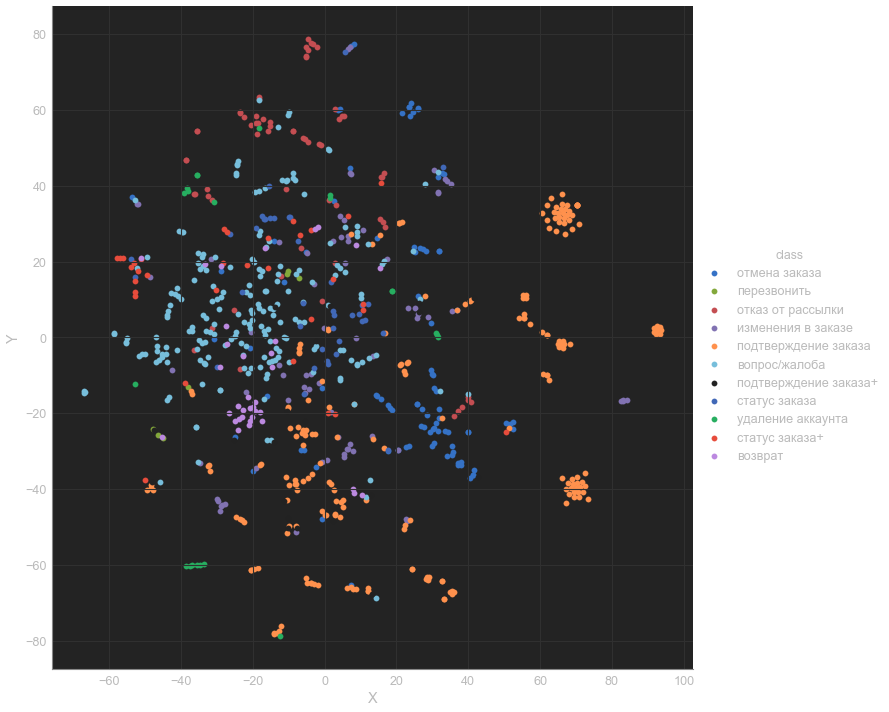

In [58]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'class': df['class']})
sns.FacetGrid(vis_df, size=10, hue='class').map(plt.scatter, "X", "Y").add_legend()

In [59]:
len(df)

813

In [60]:
df.head()

,class,text,text_tokens,digits_tokens,text_tokens_str
Index,,,,,
0,отмена заказа,"""Добрый день! Сообщаю, что , к сожалению, в...","[добрый, день, сообщаю, что, к, сожалению, вын...",[200178492],добрый день сообщаю что к сожалению вынуждена ...
1,отмена заказа,"""Добрый день! Хочу отменить Заказы:#200286822...","[добрый, день, хочу, отменить, заказы, и]","[200286822, 200247322, 200268662]",добрый день хочу отменить заказы и
2,перезвонить,"перезвонить по тел.89041792048""""","[перезвонить, по, тел]",[89041792048],перезвонить по тел
3,отказ от рассылки,"""Добрый день! Пожалуйста, исключите меня из в...","[добрый, день, пожалуйста, исключите, меня, из...",[],добрый день пожалуйста исключите меня из вашей...
4,изменения в заказе,"""Анна добрый день! Нас не будет в городе в пер...","[анна, добрый, день, нас, не, будет, в, городе...",[],анна добрый день нас не будет в городе в перио...


In [61]:
# df.drop(df[df['tokens'].apply(len)>80].index)

In [62]:
# glove_dict = {}
# with open('glove/multilingual_embeddings.txt', 'r', encoding='utf8') as f:
#     for line in f:
#         l = line.split()
#         glove_dict[l[0]] = np.array(l[1:], dtype='float32')

In [63]:
def save_obj(name, obj):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [64]:
try
    ft_dict = load_obj('fasttext/ft_dict.pkl')
except:    
    ft_dict = {}
    with open('fasttext/ft_native_300_ru_twitter_nltk_word_tokenize.vec', 'r', encoding='utf8') as f:
        for line in tqdm(f):
            l = line.split()
            ft_dict[l[0]] = np.array(l[1:], dtype='float32')
    save_obj('fasttext/ft_dict.pkl', ft_dict)
#     json.dump(ft_dict, open("fasttext/ft_dict.json", 'w'))  

In [65]:
df['lemms'] = lemms

In [66]:
group = df[['class', 'lemms']].groupby('class').sum()

In [67]:
classes = dict(zip(group.index.to_list(), range(len(group.index.to_list()))))

In [68]:
classes

{'возврат': 0,
 'вопрос/жалоба': 1,
 'изменения в заказе': 2,
 'отказ от рассылки': 3,
 'отмена заказа': 4,
 'перезвонить': 5,
 'подтверждение заказа': 6,
 'подтверждение заказа+': 7,
 'статус заказа': 8,
 'статус заказа+': 9,
 'удаление аккаунта': 10}

In [69]:
# grouped_lemms = group['lemms'].to_list()
grouped_lemms = lemms.to_list()

In [70]:
# len(grouped_lemms[3])


In [71]:
dictionary = Dictionary(grouped_lemms)
corpus = [dictionary.doc2bow(text) for text in grouped_lemms]
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [72]:
corpus_tfidf_dcts = [{k: v for k, v in corpus} for corpus in corpus_tfidf]

In [73]:
df.head(1)

,class,text,text_tokens,digits_tokens,text_tokens_str,lemms
Index,,,,,,
0,отмена заказа,"""Добрый день! Сообщаю, что , к сожалению, в...","[добрый, день, сообщаю, что, к, сожалению, вын...",[200178492],добрый день сообщаю что к сожалению вынуждена ...,"[сообщаю, сожалению, вынуждена, снять, свой, з..."


In [74]:
len(corpus_tfidf_dcts), len(df)

(813, 813)

In [75]:
df['corpus_tfidf_dcts'] = corpus_tfidf_dcts

In [76]:
df

,class,text,text_tokens,digits_tokens,text_tokens_str,lemms,corpus_tfidf_dcts
Index,,,,,,,
0,отмена заказа,"""Добрый день! Сообщаю, что , к сожалению, в...","[добрый, день, сообщаю, что, к, сожалению, вын...",[200178492],добрый день сообщаю что к сожалению вынуждена ...,"[сообщаю, сожалению, вынуждена, снять, свой, з...","{0: 0.4755103124264967, 1: 0.06490436989234061..."
1,отмена заказа,"""Добрый день! Хочу отменить Заказы:#200286822...","[добрый, день, хочу, отменить, заказы, и]","[200286822, 200247322, 200268662]",добрый день хочу отменить заказы и,"[хочу, отменить, заказы]","{6: 0.6442133457813933, 7: 0.5186076454562839,..."
2,перезвонить,"перезвонить по тел.89041792048""""","[перезвонить, по, тел]",[89041792048],перезвонить по тел,"[перезвонить, тел]","{9: 0.7521029428114379, 10: 0.6590456459262704}"
3,отказ от рассылки,"""Добрый день! Пожалуйста, исключите меня из в...","[добрый, день, пожалуйста, исключите, меня, из...",[],добрый день пожалуйста исключите меня из вашей...,"[пожалуйста, исключите, вашей, рассылки]","{11: 0.4788162998876139, 12: 0.723990998130736..."
4,изменения в заказе,"""Анна добрый день! Нас не будет в городе в пер...","[анна, добрый, день, нас, не, будет, в, городе...",[],анна добрый день нас не будет в городе в перио...,"[анна, не, городе, период, июня, июня, возможн...","{15: 0.23023243118717232, 16: 0.22226623347383..."
6,отмена заказа,"""отказываюсь от данного заказа, просьба отмени...","[отказываюсь, от, данного, заказа, просьба, от...",[200538292],отказываюсь от данного заказа просьба отменить...,"[отказываюсь, данного, заказа, просьба, отмени...","{7: 0.2869854649425044, 24: 0.4654578580264029..."
7,подтверждение заказа,"""Здравствуйте, заказ Дата: 15.05.2013 11:07...","[здравствуйте, заказ, дата, номер, заказа, спо...",[200118362],здравствуйте заказ дата номер заказа способ оп...,"[заказ, дата, номер, заказа, способ, оплаты, о...","{1: 0.061459462302728585, 25: 0.30575689726446..."
8,вопрос/жалоба,"здравствуйте, меня интересует могу ли отказать...","[здравствуйте, меня, интересует, могу, ли, отк...",[],здравствуйте меня интересует могу ли отказатьс...,"[интересует, могу, отказаться, доставки, воспо...","{35: 0.3228729935596814, 36: 0.188275796630604..."
9,вопрос/жалоба,"""Добрый день! Пытаюсь оформить заказ на люстр...","[добрый, день, пытаюсь, оформить, заказ, на, л...",[89051057575],добрый день пытаюсь оформить заказ на люстры и...,"[пытаюсь, оформить, заказ, люстры, канделябр, ...","{1: 0.07040764690296657, 10: 0.257914545904828..."


In [77]:
def sentence_embed(row):
    i = 0
    sent_emb = np.zeros(100)
    length = 0
    tfidf_sum = 0
    if row['lemms']:
        for word, tfidf in zip(row['lemms'], row['corpus_tfidf_dcts']):
            if length<80:
                try:
#                     tfidf = corpus_tfidf_dcts[i][dictionary.token2id[word]]
#                     if tfidf:
                    tfidf_sum += tfidf
                    sent_emb += ft_dict[word]*tfidf
                    length += 1
#                     else:
#                         continue
                except:
                    continue
            else:
                break
    if tfidf_sum:
        return sent_emb / tfidf_sum / length
    else:
        return sent_emb 

In [78]:
# def sentence_embed(row):
#     sent_emb = np.zeros(300)
#     length = 0
#     tfidf_sum = 0
#     if row['lemms']:
#         for word in row['lemms']:
#             if length<80:
#                 try:
#                     tfidf = corpus_tfidf_dcts[classes[row['class']]][dictionary.token2id[word]]
#                     if tfidf:
#                         tfidf_sum += tfidf
#                         sent_emb += glove_dict[word]*tfidf
#                         length += 1
#                     else:
#                         continue
#                 except:
#                     continue
#             else:
#                 break
#     if tfidf_sum:
#         return sent_emb / tfidf_sum / length
#     else:
#         return sent_emb 

In [79]:

df['sentence_embedding'] = df.apply(sentence_embed, axis=1)

In [80]:
vectors = np.stack(df['sentence_embedding'].values)
vectors = np.nan_to_num(vectors, copy=True)
# X_reduced = TruncatedSVD(n_components=30, random_state=0).fit_transform(vectors)
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(vectors)

C:\Users\psv52\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


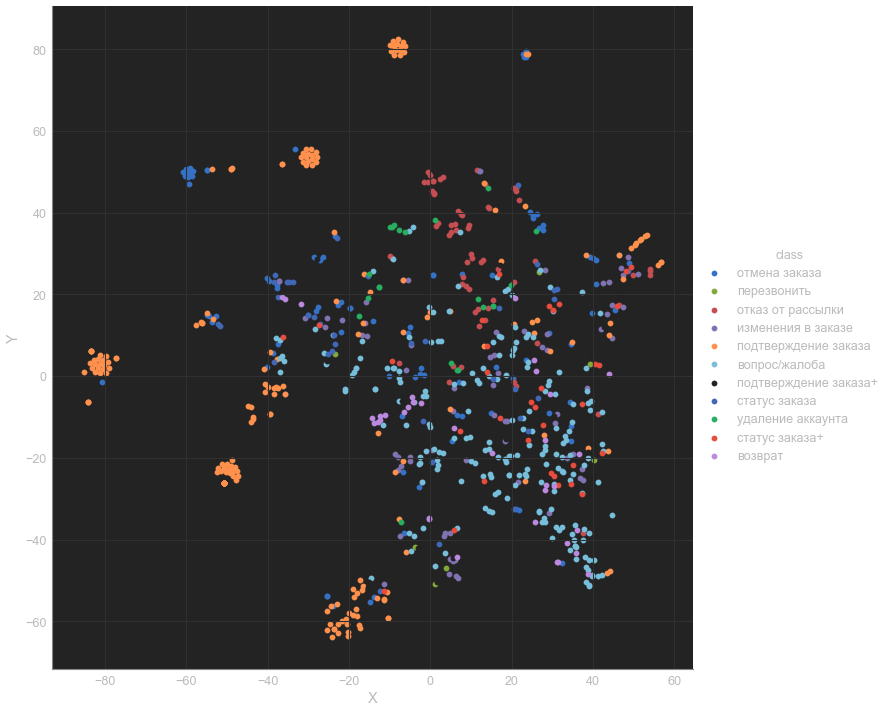

In [81]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'class': df['class']})
sns.FacetGrid(vis_df, size=10, hue='class').map(plt.scatter, "X", "Y").add_legend()

In [82]:
classes

{'возврат': 0,
 'вопрос/жалоба': 1,
 'изменения в заказе': 2,
 'отказ от рассылки': 3,
 'отмена заказа': 4,
 'перезвонить': 5,
 'подтверждение заказа': 6,
 'подтверждение заказа+': 7,
 'статус заказа': 8,
 'статус заказа+': 9,
 'удаление аккаунта': 10}

In [83]:
df['y'] = df['class']
# .map(classes)

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from collections import defaultdict

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df['text_tokens'], df['y'], 
                                                    stratify=df['y'], test_size=0.2, random_state=1)

In [86]:
class TfidfEmbeddingVectorizer():
    def __init__(self, word_emb):
        self.word_emb = word_emb
        self.word_weight = None
        self.dim=100
        
    def fit(self, X, y):
        
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word_weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word_emb[w] * self.word_weight[w]
                         for w in words if w in self.word_emb] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [88]:

pipeline_tfidf_lgr = Pipeline([("tfidf fasttext vectorizer", TfidfEmbeddingVectorizer(ft_dict)), 
                        ("LGR", LogisticRegression())])

pipeline_tfidf_rfc = Pipeline([("tfidf fasttext vectorizer", TfidfEmbeddingVectorizer(ft_dict)), 
                        ("RFC", RandomForestClassifier(n_estimators=300, n_jobs=-1))])

pipeline_tfidf_svc = Pipeline([("tfidf fasttext vectorizer", TfidfEmbeddingVectorizer(ft_dict)), 
                        ("SVC", SVC(kernel='poly'))])

In [89]:
pipeline_tfidf_xgb = Pipeline([("tfidf fasttext vectorizer", TfidfEmbeddingVectorizer(ft_dict)), 
                        ("XGB", XGBClassifier(n_estimators=300, n_jobs=-1))])

In [90]:
pipeline_tfidf_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf fasttext vectorizer',
                 <__main__.TfidfEmbeddingVectorizer object at 0x0000020E3B8F00B8>),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=300, n_jobs=-1, nthread=None,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [91]:
pipeline_tfidf_lgr.fit(X_train, y_train)
pipeline_tfidf_rfc.fit(X_train, y_train)
pipeline_tfidf_svc.fit(X_train, y_train)

C:\Users\psv52\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\psv52\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\psv52\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf fasttext vectorizer',
                 <__main__.TfidfEmbeddingVectorizer object at 0x0000020E3B8C8F28>),
                ('SVC',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [92]:
pipeline_tfidf_xgb.score(X_train, y_train), pipeline_tfidf_xgb.score(X_test, y_test)

(1.0, 0.7116564417177914)

In [93]:
pipeline_tfidf_lgr.score(X_train, y_train), pipeline_tfidf_lgr.score(X_test, y_test)


(0.936923076923077, 0.7607361963190185)

In [105]:
pipeline_tfidf_rfc.score(X_train, y_train), pipeline_tfidf_rfc.score(X_test, y_test)

(1.0, 0.656441717791411)

In [106]:
pipeline_tfidf_svc.score(X_train, y_train), pipeline_tfidf_svc.score(X_test, y_test)


(0.8615384615384616, 0.7791411042944786)

In [96]:
# 

In [499]:
# clsf = RandomForestClassifier(n_estimators=100)
# clsf_lgr = LogisticRegression()

In [500]:
# clsf_xgb = XGBClassifier(n_estimators=500)

In [501]:
# clsf.fit(X_train, y_train)
# clsf_lgr.fit(X_train, y_train)

In [502]:
# clsf_xgb.fit(X_train, y_train)

In [503]:
# clsf.score(X_train, y_train), clsf_lgr.score(X_train, y_train), clsf_xgb.score(X_train, y_train)

In [504]:
# clsf.score(X_test, y_test), clsf_lgr.score(X_test, y_test),  clsf_xgb.score(X_test, y_test)

In [97]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [98]:
classes

{'возврат': 0,
 'вопрос/жалоба': 1,
 'изменения в заказе': 2,
 'отказ от рассылки': 3,
 'отмена заказа': 4,
 'перезвонить': 5,
 'подтверждение заказа': 6,
 'подтверждение заказа+': 7,
 'статус заказа': 8,
 'статус заказа+': 9,
 'удаление аккаунта': 10}

In [99]:
y_pr = pipeline_tfidf_svc.predict(df['text_tokens'])

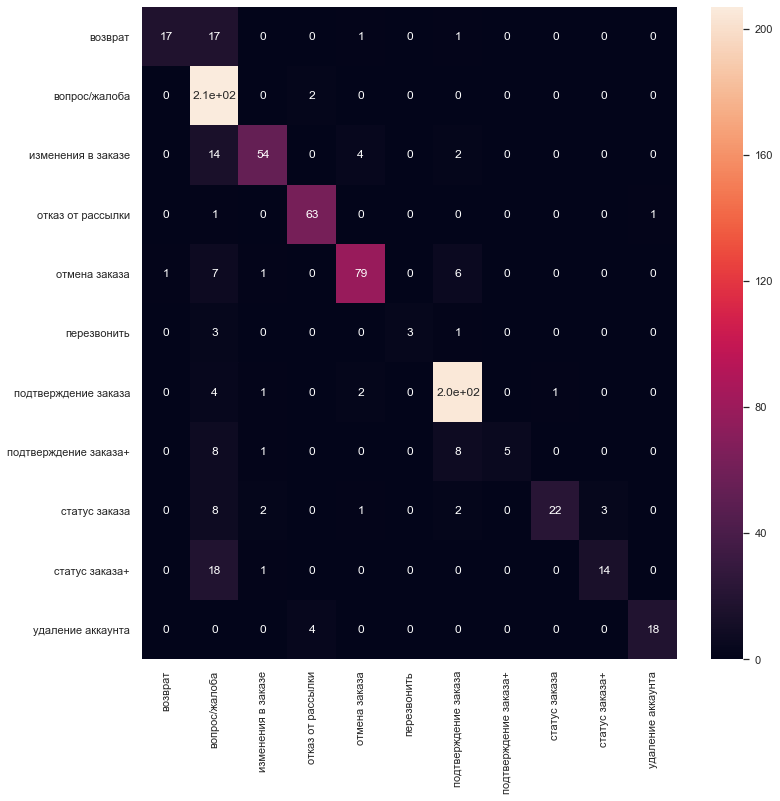

In [100]:
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(confusion_matrix(df['y'], y_pr), annot=True, 
            xticklabels=classes.keys(), yticklabels=classes.keys())

In [101]:
df['predicted'] = y_pr

In [102]:
cols = ['class', 'predicted', 'text']

In [103]:
pd.options.display.max_colwidth = 500

In [104]:
len(df[df['class']!=df['predicted']][cols])

126

In [107]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, PReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
from livelossplot.tf_keras import PlotLossesCallback

In [108]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
# BATCH_SIZE = 256
EPOCHS = 500

In [109]:
sentences = df['text_tokens'].values

In [110]:
classes_ohe = dict(zip(classes.keys(), np.eye(len(classes))))

In [111]:
idx_to_classes = dict(zip(range(len(classes)), classes))

In [112]:

targets = np.stack(df['y'].map(classes_ohe).values)

In [113]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [114]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 559
min sequence length: 1
median sequence length: 12


In [115]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 3741 unique tokens.


In [116]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (813, 100)


In [117]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = ft_dict.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector

In [118]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [119]:
data.shape

(813, 100)

In [120]:
targets.shape

(813, 11)

In [121]:
adam = Adam(lr=3e-4)
nadam = Nadam(lr=2e-4)
rmsp = RMSprop(lr=3e-4)


act_func = LeakyReLU()

'ELU, LeakyReLU'

Instructions for updating:
Colocations handled automatically by placer.


'ELU, LeakyReLU'

In [122]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation=act_func, kernel_regularizer=l2(2e-2))(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Conv1D(128, 3, activation=act_func, kernel_regularizer=l2(2e-2))(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Conv1D(128, 3, activation=act_func, kernel_regularizer=l2(2e-2))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation=act_func, kernel_regularizer=l2(2e-3))(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
output = Dense(len(classes), activation='softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [124]:
data_train, data_val, targets_train, targets_val = train_test_split(data, targets, stratify=targets, test_size=VALIDATION_SPLIT)

In [123]:
model = Model(input_, output)
model.compile(
  loss='categorical_crossentropy',
  optimizer=nadam,
  metrics=['accuracy']
)

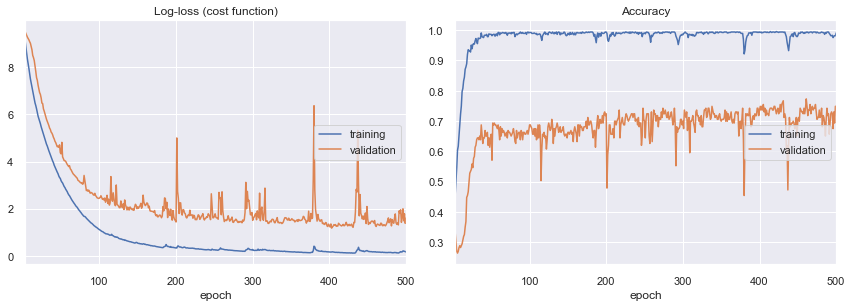

Log-loss (cost function):
training   (min:    0.116, max:   10.119, cur:    0.161)
validation (min:    1.177, max:    9.777, cur:    1.596)

Accuracy:
training   (min:    0.200, max:    0.995, cur:    0.991)
validation (min:    0.233, max:    0.773, cur:    0.748)
650/650 [==============================] - 1s 950us/sample - loss: 0.1614 - acc: 0.9908 - val_loss: 1.5960 - val_acc: 0.7485


In [125]:
r = model.fit(
    data_train,
    targets_train,
    epochs=EPOCHS,
    validation_data=(data_val, targets_val),
    callbacks=[PlotLossesCallback()],
)

In [126]:
# plt.plot(r.history['loss'], label='loss')
# plt.plot(r.history['val_loss'], label='val_loss')
# plt.legend()
# plt.show()

In [127]:
# plt.plot(r.history['acc'], label='acc')
# plt.plot(r.history['val_acc'], label='val_acc')
# plt.legend()
# plt.show()

In [128]:
pred = model.predict(data)
# aucs = []
# for j in range(13):
#     auc = roc_auc_score(targets[:,j], p[:,j])
#     aucs.append(auc)
# print(np.mean(aucs))

In [129]:
def decode_prediction(pred):
    res = []
    for pr in pred:
        res.append(idx_to_classes[np.argmax(pr)])
    return res

In [130]:
y_pr = decode_prediction(pred)

In [131]:
df['predicted'] = y_pr

In [132]:
len(df[df['class']!=df['predicted']][cols])

45

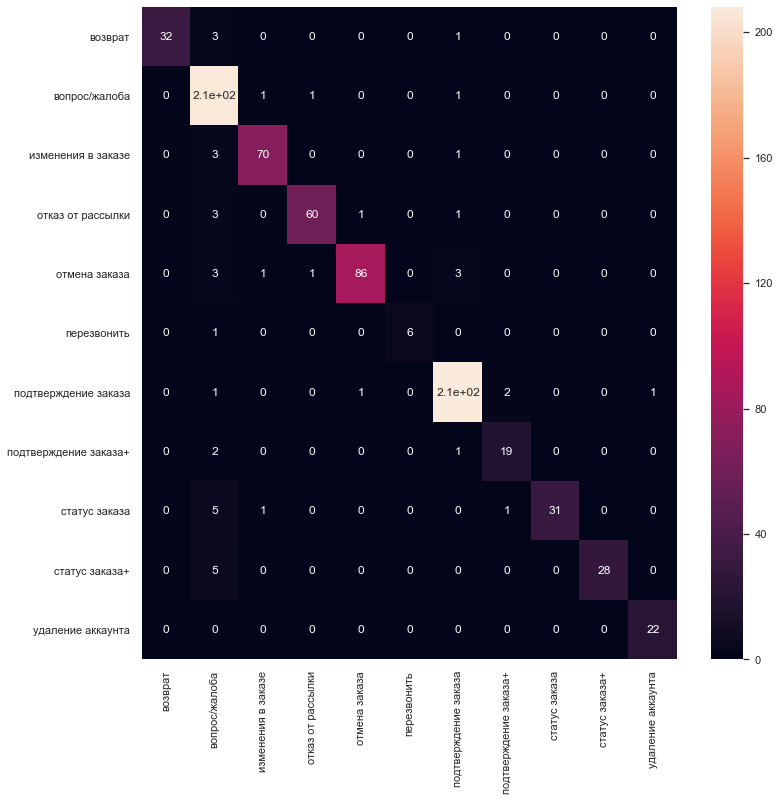

In [133]:
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(confusion_matrix(df['y'], y_pr), annot=True, 
            xticklabels=classes.keys(), yticklabels=classes.keys())

In [134]:
accuracy_score(df['y'], y_pr)

0.9446494464944649

In [135]:
# df[df['class']!=df['predicted']][cols]

In [136]:
nadam_2 = Nadam(lr=4e-5)
EPOCHS_2 = 600

In [137]:
input_1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_1 = embedding_layer(input_1)

x_1 = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(3e-2))(embedding_1)
x_1 = Dropout(0.4)(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = MaxPooling1D(pool_size=2)(x_1)
x_1 = Flatten()(x_1)
# channel 2
x_2 = Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(3e-2))(embedding_1)
x_2 = Dropout(0.4)(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = MaxPooling1D(pool_size=2)(x_2)
x_2 = Flatten()(x_2)
# channel 3
x_3 = Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=l2(3e-2))(embedding_1)
x_3 = Dropout(0.4)(x_3)
x_3 = BatchNormalization()(x_3)
x_3 = MaxPooling1D(pool_size=2)(x_3)
x_3 = Flatten()(x_3)
# merge
x_ = concatenate([x_1, x_2, x_3])
# interpretation
x_ = Dense(128, activation='relu', kernel_regularizer=l2(3e-2))(x_)
x_ = Dropout(0.4)(x_)
x_ = BatchNormalization()(x_)
output_ = Dense(len(classes), activation='softmax')(x_)

In [138]:
model_2 = Model(input_1, output_)

In [139]:
model_2.compile(
  loss='categorical_crossentropy',
  optimizer=nadam_2,
  metrics=['accuracy']
)

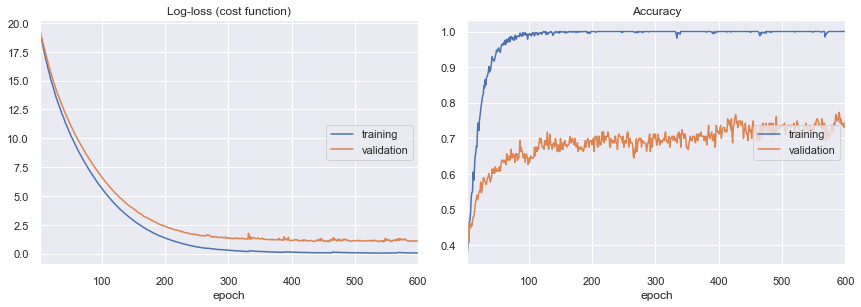

Log-loss (cost function):
training   (min:    0.043, max:   20.246, cur:    0.048)
validation (min:    1.013, max:   19.748, cur:    1.079)

Accuracy:
training   (min:    0.234, max:    1.000, cur:    1.000)
validation (min:    0.380, max:    0.773, cur:    0.748)
650/650 [==============================] - 1s 1ms/sample - loss: 0.0481 - acc: 1.0000 - val_loss: 1.0791 - val_acc: 0.7485


In [140]:
r_2 = model_2.fit(
    data_train,
    targets_train,
    epochs=EPOCHS_2,
    validation_data=(data_val, targets_val),
    callbacks=[PlotLossesCallback()],
)

In [141]:
# plt.plot(r_2.history['loss'], label='loss')
# plt.plot(r_2.history['val_loss'], label='val_loss')
# plt.legend()
# plt.show()

In [142]:
# plt.plot(r_2.history['acc'], label='acc')
# plt.plot(r_2.history['val_acc'], label='val_acc')
# plt.legend()
# # plt.show()

In [143]:
pred_2 = model_2.predict(data)
# aucs = []
# for j in range(13):
#     auc = roc_auc_score(targets[:,j], p[:,j])
#     aucs.append(auc)
# print(np.mean(aucs))

In [144]:
y_pr_2 = decode_prediction(pred_2)

In [145]:
df['predicted_2'] = y_pr_2

In [146]:
len(df[df['class']!=df['predicted_2']][cols])

41

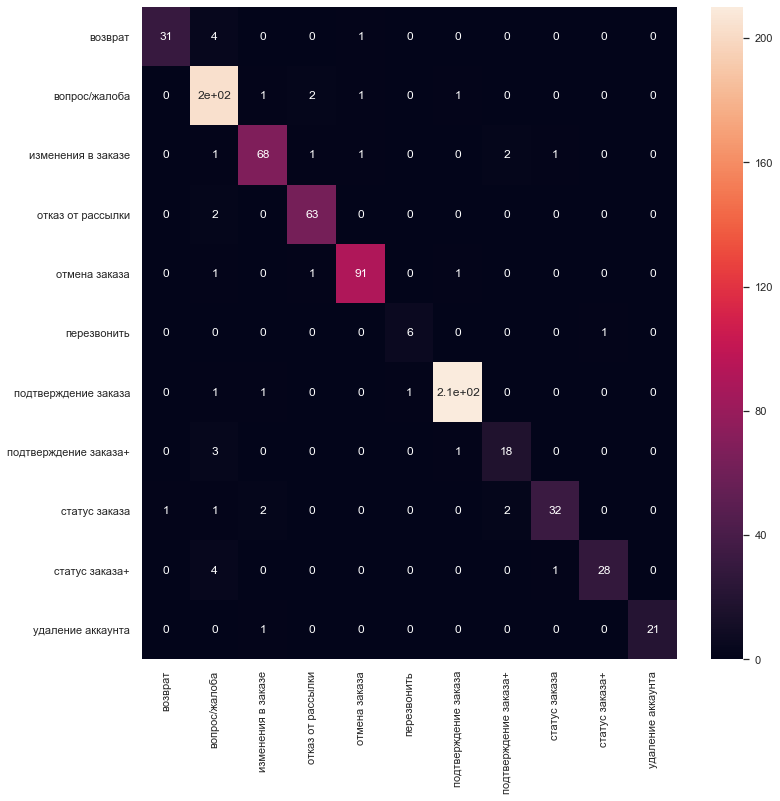

In [147]:
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(confusion_matrix(df['y'], y_pr_2), annot=True, 
            xticklabels=classes.keys(), yticklabels=classes.keys())

In [148]:
accuracy_score(df['y'], y_pr_2)

0.949569495694957